In [1]:
import json
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from configparser import ConfigParser
from pathlib import Path
from IPython.display import display, Markdown

## Load game configuration

In [2]:
ROOT = Path('..').resolve()

"""Identifies the config file, loads it and returns a config dictionary."""
# Select configuration file: config.cfg, config-default.cfg, first of any other *.cfg    
if (ROOT/'config.cfg').is_file():
    p2config = ROOT / 'config.cfg'
elif (ROOT/'config-default.cfg').is_file():
    p2config = ROOT / 'config-default.cfg'
elif len(list(ROOT.glob('config*.cfg'))) > 0:
    p2config = list(ROOT.glob('config*.cfg'))[0]
else:
    raise FileNotFoundError('No configuration file found. Should be a *.cfg file')

cfg = ConfigParser()
cfg.read(p2config)
config_dict = {k:v for k,v in cfg['DEFAULT'].items()}
numerical_values = ['duration-minutes']
for k in numerical_values:
    config_dict[k] = int(config_dict[k])

p2games = ROOT/ f"config/{config_dict['cfg-folder']}/{config_dict['games']}"
p2cast = ROOT/ f"config/{config_dict['cfg-folder']}/{config_dict['cast']}"
p2prompts = ROOT/ f"config/{config_dict['cfg-folder']}/{config_dict['prompts']}"

with open(p2games, 'r') as fp: games = json.load(fp)
with open(p2cast, 'r') as fp: cast = sorted([l.rstrip('\n') for l in fp.readlines()])

In [3]:
# Define a function to apply conditional formatting
def color_non_zeros(val):
    color = '' if val > 0 else ''
    background = 'steelblue' if val > 0 else ''
    return f'color: {color}; background-color: {background}'

# # # Apply the function to the DataFrame
# styled_df = df.style.map(color_non_zeros)

# # # Display the styled DataFrame
# styled_df

## Game and Hosting exclusion summary

### Game Exclusions

In [4]:
game_exlusion = {g['name']: g['exclude'] for g in games.values()}
df = pd.DataFrame(index=game_exlusion.keys(),columns=cast).fillna(0)
for idx, excl in game_exlusion.items():
    excluded_cast = list(set(cast).intersection(set(excl)))
    df.loc[idx, excluded_cast] = 1
df = pd.concat([df.sum(axis=0).to_frame(name='Total All Games').T, df])
game_exlusion_summary = df.sum(axis=1).iloc[1:]

display(Markdown('### Game Exclusions:'))
df_styled = df.style.map(color_non_zeros)
display(df_styled)

### Game Exclusions:

,Alex,Charles,Chris,Don,Eddie,Elva,Etienne,Fulvio,Grace,Haili,Harry,Jennel,Knick,Meg,Punk,Stacey,Xu,Yirong
Total All Games,2,2,2,4,4,2,2,1,2,2,2,0,2,2,2,1,2,2
A Date with Me,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Chain Death,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Emotion Roller Coaster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Emotional Floorplan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Everyone Dies,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Forward Reverse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Genres,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Last Comic Standing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Mutant Debate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
host_include = {g['name']: g['host_include'] for g in games.values()}
df = pd.DataFrame(index=host_include.keys(),columns=cast).fillna(0)
for idx, incl in host_include.items():
    hosting_cast = list(set(cast).intersection(set(incl)))
    df.loc[idx, hosting_cast] = 1
df = pd.concat([df.sum(axis=0).to_frame(name='Total All Games').T, df])

display(Markdown('### Hosting Inclusions:'))
df_styled = df.style.map(color_non_zeros)
display(df_styled)

### Hosting Inclusions:

,Alex,Charles,Chris,Don,Eddie,Elva,Etienne,Fulvio,Grace,Haili,Harry,Jennel,Knick,Meg,Punk,Stacey,Xu,Yirong
Total All Games,0,0,3,0,1,1,8,1,6,1,0,0,6,0,1,0,0,7
A Date with Me,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chain Death,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1
Emotion Roller Coaster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Emotional Floorplan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Everyone Dies,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
Forward Reverse,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Genres,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Last Comic Standing,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
Mutant Debate,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1


### Hosting Exclusions

In [6]:
host_exclude = {g['name']: g['host_exclude'] for g in games.values()}
df = pd.DataFrame(index=host_exclude.keys(),columns=cast).fillna(0)
for idx, excl in host_exclude.items():
    hosting_cast = list(set(cast).intersection(set(excl)))
    df.loc[idx, hosting_cast] = 1
df = pd.concat([df.sum(axis=0).to_frame(name='Total All Games').T, df])
game_exlusion_summary = df.sum(axis=1).iloc[1:]
display(game_exlusion_summary)

display(Markdown('### Hosting Exclusions:'))
df_styled = df.style.map(color_non_zeros)
display(df_styled)

A Date with Me            7
Chain Death               6
Emotion Roller Coaster    5
Emotional Floorplan       5
Everyone Dies             5
Forward Reverse           4
Genres                    5
Last Comic Standing       7
Mutant Debate             7
One Three Five            5
Pillars                   5
Puppets                   5
Questions Only            5
Sit, Stand, Lie           5
Story, Story, Die!        5
Stunt Doubles             6
Suitcase                  6
Sure Ding                 5
TV Box                    5
Two lines                 5
World's Worst             7
Musical Paper Chase       7
Musical Freeze            7
dtype: int64

### Hosting Exclusions:

,Alex,Charles,Chris,Don,Eddie,Elva,Etienne,Fulvio,Grace,Haili,Harry,Jennel,Knick,Meg,Punk,Stacey,Xu,Yirong
Total All Games,1,0,1,23,3,0,0,2,0,22,23,2,3,0,3,23,23,0
A Date with Me,0,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,1,0
Chain Death,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0
Emotion Roller Coaster,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0
Emotional Floorplan,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0
Everyone Dies,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0
Forward Reverse,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0
Genres,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0
Last Comic Standing,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0
Mutant Debate,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,1,1,0


## Plot stats

run one of the following command in the CLI first with selected number of sessions, or run the next cell:

- `python test_player_stats.py --nb-sessions 10000`
- `python test_player_stats.py --nb-sessions 10000 --with-hosting`

In [9]:
RUN_IN_NOTEBOOK = False

if RUN_IN_NOTEBOOK:

    current_dir = Path().resolve()
    if current_dir.name == 'nbs':
        os.chdir(current_dir.parent)
    elif  current_dir.name == 'chris':
        pass
    else:
        raise FileNotFoundError('Please run this notebook from the nbs or chris directory.')

    ! python test_player_stats.py --nb-sessions 1000 --with-hosting

    os.chdir(current_dir)

In [10]:
def plot_boxplot(df, exclusions=None, title=None, figsize=(12, 6)):

    fig, ax = plt.subplots(1,1,figsize=figsize)
    bg_color = 'silver'
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)
    boxplot = df.plot(
        ax=ax,
        kind='box', 
        notch=True,
        sym='',
        color=dict(boxes='green', whiskers='gray', medians='green', caps='gray')
        )
    
    means = df.mean(axis=0)
    boxplot_stats = df.describe().T
    third_quartiles = boxplot_stats['75%']
    max_value = boxplot_stats['max'].max()
    
    for i, (m, q3) in enumerate(zip(means, third_quartiles)):
        y_pos = 0.01
        # add annotation for mean value
        plt.annotate(
            f'{m:.2f}', 
            xy=(i + 1, m), 
            xytext=(i + 1, q3+0.01),  # Adjust the offset as needed
            ha='center', 
            color='green',
        )
    
    for i, nb_excl in enumerate(exclusions):
        y_pos = 0.02
        # add annnotation nb exclusions
        plt.annotate(
            f'{nb_excl}', 
            xy=(i + 1, y_pos), 
            xytext=(i + 1, y_pos),  # Adjust the offset as needed
            ha='center', 
            color='gray'
        )
    
    if title:
        title_font = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 16}
        ax.set_title(title, fontdict=title_font)
    boxplot.set_xlabel('Players')
    boxplot.set_ylabel('Share')
    boxplot.set_ylim(0, max_value)

    plt.xticks(rotation=45)
    plt.show();

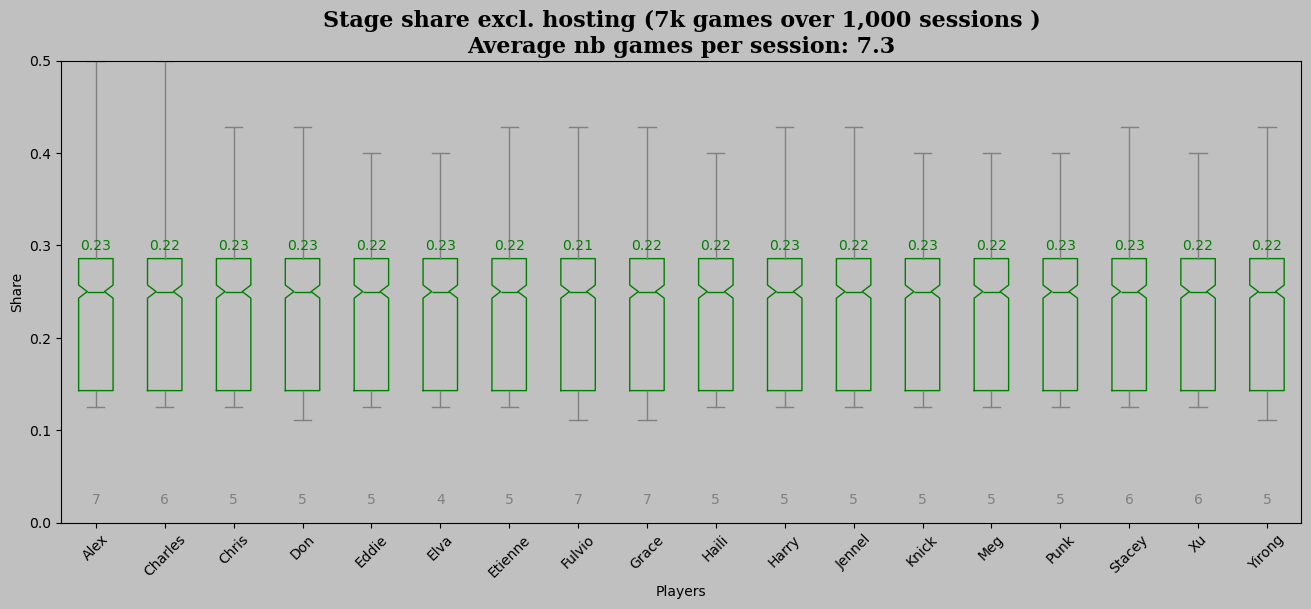

In [13]:
p2stats_wo_host = Path('../logs/stats_test_wo_host.csv')
if p2stats_wo_host.exists():
    df = pd.read_csv(p2stats_wo_host, index_col=0).loc[:, ['Games'] + cast].iloc[1:, :]
    mean_nb_games = df.Games.mean()
    players = list(df.columns)
    players.remove('Games')
    share_wo = df.loc[:, players].div(df['Games'], axis=0)
    title = f'Stage share excl. hosting ({df["Games"].sum()//1000:,d}k games over {df.shape[0]:,d} sessions )' + '\n' + f'Average nb games per session: {mean_nb_games:.1f}'
    plot_boxplot(share_wo, exclusions=game_exlusion_summary, title=title, figsize=(16,6));

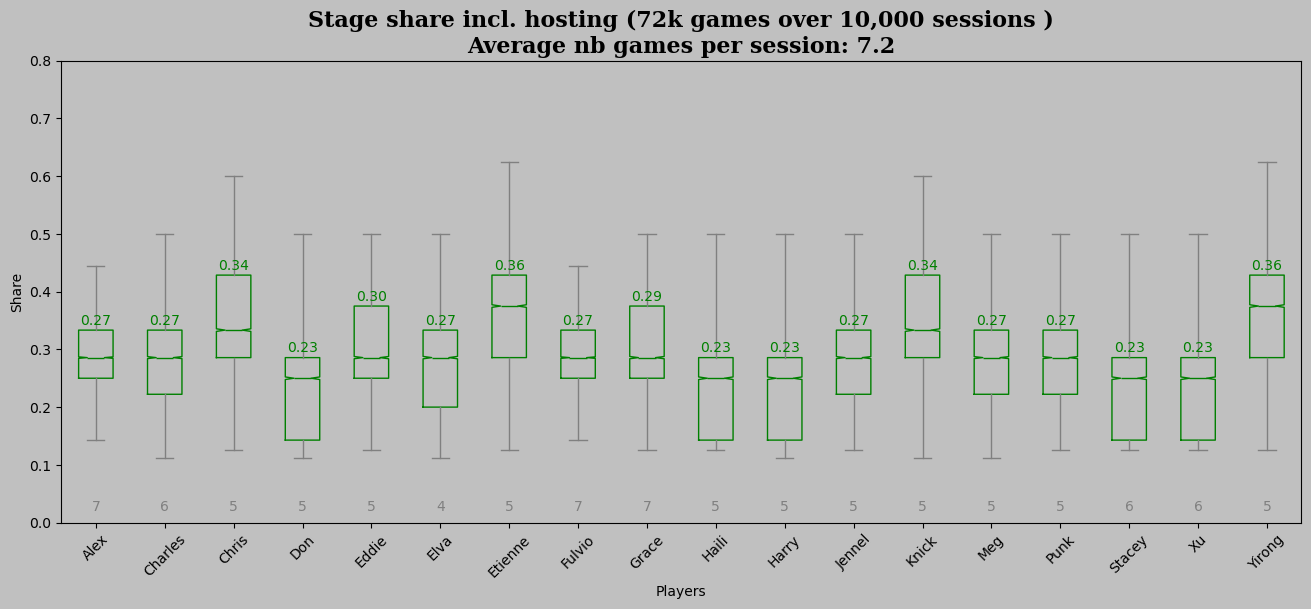

In [14]:
p2stats_w_host = Path('../logs/stats_test_w_host.csv')
if  p2stats_w_host.exists():
    df = pd.read_csv(p2stats_w_host, index_col=0).loc[:, ['Games'] + cast].iloc[1:, :]
    mean_nb_games = df['Games'].mean()
    players = list(df.columns)
    players.remove('Games')
    share_w = df.loc[:, players].div(df['Games'], axis=0)
    title = f'Stage share incl. hosting ({df["Games"].sum()//1000:,d}k games over {df.shape[0]:,d} sessions )' + '\n' + f'Average nb games per session: {mean_nb_games:.1f}'
    plot_boxplot(share_w, exclusions=game_exlusion_summary, title=title, figsize=(16,6));